<a href="https://colab.research.google.com/github/m677s345/EECS731_MS_Project4/blob/main/EECS_MS_Project4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Data Cleaning

In [1]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science


     |████████████████████████████████| 51kB 3.6MB/s 
project_name [project_name]: 
repo_name [project_name]: 
author_name [Your name (or your organization/company/team)]: 
description [A short description of the project.]: 
Select open_source_license:
1 - MIT
2 - BSD-3-Clause
3 - No license file
Choose from 1, 2, 3 [1]: 
s3_bucket [[OPTIONAL] your-bucket-for-syncing-data (do not include 's3://')]: 
aws_profile [default]: 
Select python_interpreter:
1 - python3
2 - python
Choose from 1, 2 [1]: 


In [75]:

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
!pip install heatmapz
from heatmap import heatmap, corrplot
df_games = pd.read_csv('/content/project_name/data/raw/mlb_elo.csv',header=0)

Column	Definition


---


date	Date of game

* season	Year of season

* neutral	Whether game was on a neutral site

* playoff	Whether game was in playoffs, and the playoff round if so

* team1	Abbreviation for home team

* team2	Abbreviation for away team

* elo1_pre	Home team's Elo rating before the game

* elo2_pre	Away team's Elo rating before the game

* elo_prob1	Home team's probability of winning according to Elo ratings

* elo_prob2	Away team's probability of winning according to Elo ratings

* elo1_post	Home team's Elo rating after the game

* elo2_post	Away team's Elo rating after the game

* rating1_pre	Home team's rating before the game

* rating2_pre	Away team's rating before the game

* pitcher1	Name of home starting pitcher

* pitcher2	Name of away starting pitcher

* pitcher1_rgs	Home starting pitcher's rolling game score before the game

* pitcher2_rgs	Away starting pitcher's rolling game score before the game

* pitcher1_adj	Home starting pitcher's adjustment to their team's rating

* pitcher2_adj	Away starting pitcher's adjustment to their team's rating

* rating_prob1	Home team's probability of winning according to team ratings and 
starting pitchers

* rating_prob2	Away team's probability of winning according to team ratings and starting pitchers

* rating1_post	Home team's rating after the game

* rating2_post	Away team's rating after the game

* score1	Home team's score

* score2	Away team's score

Cleaning up the data I assumed that the data for the past 20 years will give over 50000 instances to use and that data was of a higher quality than previous data. I also assumed that playoffs and turf were not useful in the determination of the score. I choose to drop some of the attributes listed because they are used in other columns of the dataset and are incorperated into a value there. One thing to note about this dataset is the lack of specific statistics relating to the score. For instance the MLB has a stastic that relates to the number of runs allowed by a pitcher. I think in order to accuratly predict the score of a contest you need to have direct scoring information for both teams offense and defence in a runs alowed and runs scored per game column. 

In [76]:
df_games = df_games.drop(df_games.index[0:20],0,inplace=False)
df_games = df_games.drop(df_games.index[50100:],0,inplace=False)
df_games = df_games.drop(['neutral','playoff','pitcher2_rgs','pitcher1_rgs','pitcher1_adj','pitcher2_adj','elo_prob1','elo_prob2',],axis=1)

Below we are making sure that the dataset does not include any Null values. We can see that the features we have retained make it so that there are no values missing.

In [91]:
print(df_games.isnull().sum(axis=0).tolist())
df_games.tail()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


,date,season,team1,team2,elo1_pre,elo2_pre,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2,del_elo1,del_elo2,del_rating1,del_rating2
50115,2000-04-09,2000,3,10,1519.075,1471.001,1521.171,1468.905,1518.577,1470.338,1360,1408,0.602488,0.397512,1520.664,1468.251,11.0,6.0,-0.349333,0.349333,4.355569,4.355569
50116,2000-04-09,2000,2,24,1551.246,1518.023,1553.782,1515.487,1550.102,1518.745,1140,1426,0.578998,0.421002,1552.720,1516.127,9.0,3.0,-0.845333,0.845333,6.853924,6.853924
50117,2000-04-09,2000,1,21,1544.483,1495.919,1545.493,1494.909,1539.121,1495.767,1245,1563,0.595734,0.404266,1539.847,1495.040,1.0,0.0,-inf,inf,0.527076,0.528529
50118,2000-04-09,2000,0,4,1484.871,1527.637,1482.883,1529.625,1485.330,1528.626,964,1331,0.472259,0.527741,1484.073,1529.882,2.0,5.0,0.397600,-0.397600,1.580049,1.577536
50119,2000-04-08,2000,29,22,1472.601,1503.061,1473.998,1501.664,1475.563,1507.857,1197,1212,0.488066,0.511934,1476.964,1506.455,10.0,9.0,-0.155222,0.155222,1.962801,1.965604


# Feature Engineering

Encoding team names and pitchers so they can be used as features. Some teams have higher chance of scoring per game than others and certain pitchers give up more runs. Hopefully these can be useful in determining the likelyhood of scoring certain amounts of runs. 

In [79]:
le_team = preprocessing.LabelEncoder()
le_team.fit(df_games['team1'].append(df_games['team2']))
df_games['team1'] = le_team.transform(df_games['team1'])
df_games['team2'] = le_team.transform(df_games['team2'])
df_games.head()

,date,season,team1,team2,elo1_pre,elo2_pre,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
20,2020-10-02,2020,22,25,1522.312734,1520.100045,1525.832831,1516.579948,1530.728125,1513.055229,Craig Stammen,Jack Flaherty,0.461857,0.538143,1534.038131,1509.745224,4.0,0.0
21,2020-10-02,2020,5,11,1517.011886,1478.403936,1513.409248,1482.006574,1520.999030,1472.069596,Yu Darvish,Sixto Sanchez,0.673112,0.326888,1517.959644,1475.108982,0.0,2.0
22,2020-10-01,2020,14,15,1596.678175,1502.693145,1598.290926,1501.080394,1604.605528,1508.163888,Clayton Kershaw,Brandon Woodruff,0.673916,0.326084,1606.065971,1506.703444,3.0,0.0
23,2020-10-01,2020,22,25,1519.722828,1522.689951,1522.312734,1520.100045,1528.808158,1514.975196,Zach Davies,Adam Wainwright,0.544395,0.455605,1530.728125,1513.055229,11.0,9.0
24,2020-10-01,2020,19,6,1545.674260,1507.785767,1547.618027,1505.842000,1531.215901,1515.390101,Mike Fiers,Dane Dunning,0.558056,0.441944,1532.981409,1513.624593,6.0,4.0


In [94]:
le_pitchers = preprocessing.LabelEncoder()
le_pitchers.fit(df_games['pitcher1'].append(df_games['pitcher2']))
df_games['pitcher1'] = le_pitchers.transform(df_games['pitcher1'])
df_games['pitcher2'] = le_pitchers.transform(df_games['pitcher2'])
df_games.head()

,date,season,team1,team2,elo1_pre,elo2_pre,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2,del_elo1,del_elo2,del_rating1,del_rating2
20,2020-10-02,2020,22,25,1522.312734,1520.100045,1525.832831,1516.579948,1530.728125,1513.055229,209,350,0.461857,0.538143,1534.038131,1509.745224,4.0,0.0,12.391083,12.391083,10.956135,10.956135
21,2020-10-02,2020,5,11,1517.011886,1478.403936,1513.409248,1482.006574,1520.999030,1472.069596,854,738,0.673112,0.326888,1517.959644,1475.108982,0.0,2.0,12.978999,12.978999,9.237870,9.237870
22,2020-10-01,2020,14,15,1596.678175,1502.693145,1598.290926,1501.080394,1604.605528,1508.163888,185,99,0.673916,0.326084,1606.065971,1506.703444,3.0,0.0,2.600966,2.600966,2.132896,2.132896
23,2020-10-01,2020,22,25,1519.722828,1522.689951,1522.312734,1520.100045,1528.808158,1514.975196,860,16,0.544395,0.455605,1530.728125,1513.055229,11.0,9.0,6.707611,6.707611,3.686273,3.686273
24,2020-10-01,2020,19,6,1545.674260,1507.785767,1547.618027,1505.842000,1531.215901,1515.390101,596,218,0.558056,0.441944,1532.981409,1513.624593,6.0,4.0,3.778230,3.778230,3.117019,3.117019


Since all the statistics are embeded in different features we may be able to look at how those features change to predict the score of the game. For instance the decrease in the elo indicates a loss but the severity of the loss seems to impace the magnitude of the drop.

In [99]:
df_games['del_elo1']=pow((df_games['elo1_pre']-df_games['elo1_post']),3)
df_games['del_elo2']=pow((df_games['elo2_pre']-df_games['elo2_post']),3)
df_games['del_rating1']=pow((df_games['rating1_pre']-df_games['rating1_post']),3)
df_games['del_rating2']=pow((df_games['rating2_pre']-df_games['rating2_post']),3)

Here we can see what has the higest correlation with the score for both teams. The size of each of the squares represent the magnitude of the coorelation I.E the strength where the color suggests the direction of the coorelation. We can see the features we have created have an inverse proportion to the team they represent but that coorelation is strong. 

season         -0.044708
team1          -0.027713
team2           0.011855
elo1_pre        0.062274
elo2_pre       -0.082618
elo1_post       0.108331
elo2_post      -0.128724
rating1_pre     0.062574
rating2_pre    -0.083985
pitcher1        0.028321
pitcher2        0.063588
rating_prob1    0.110692
rating_prob2   -0.110692
rating1_post    0.106199
rating2_post   -0.127648
score1          1.000000
score2          0.037195
del_elo1       -0.494332
del_elo2        0.494331
del_rating1    -0.477187
del_rating2     0.477188
Name: score1, dtype: float64
season         -0.042288
team1          -0.029881
team2           0.005065
elo1_pre       -0.087815
elo2_pre        0.068900
elo1_post      -0.137369
elo2_post       0.118605
rating1_pre    -0.089420
rating2_pre     0.070266
pitcher1        0.064138
pitcher2        0.028000
rating_prob1   -0.121614
rating_prob2    0.121614
rating1_post   -0.136340
rating2_post    0.117314
score1          0.037195
score2          1.000000
del_elo1        0.595

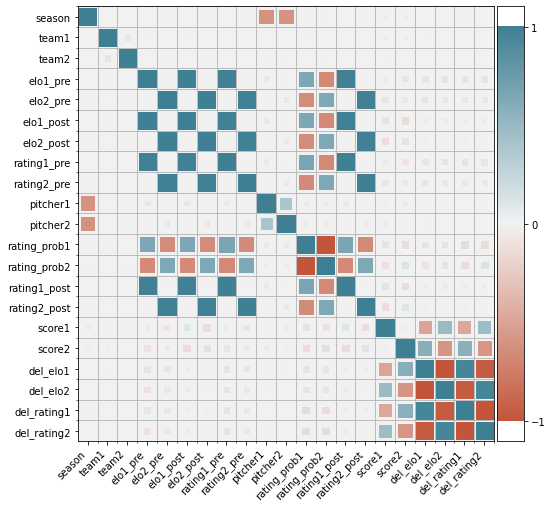

In [100]:
print(df_games.corr()['score1'])
print(df_games.corr()['score2'])
corr = df_games.corr()['score1']
plt.figure(figsize=(8, 8))
corrplot(df_games.corr(), size_scale=300);


In [101]:

# Creating test and train split
scores = pd.DataFrame(df_games['score1'])
scores['score2'] = df_games['score2']
score=scores.values
features = df_games[['team1','team2','del_elo1','del_elo2','pitcher1','pitcher2', 'rating_prob1', 'rating_prob2', 'del_rating1', 'del_rating2' ]]
X_train1, X_test1, y_train1, y_test1 = train_test_split(features, scores, test_size=0.1)

In [102]:
print(score)

[[ 4.  0.]
 [ 0.  2.]
 [ 3.  0.]
 ...
 [ 1.  0.]
 [ 2.  5.]
 [10.  9.]]


# Model Selection 

Creating a random tree ensamble to handle the regression was something that has been done by several people looking to predict win loss statistics. This use for the model is far better than the use for this project because winning or losing is a binary choice where there are a finite but large number of scoring combinations for guesssing runs. However this is the first instance of seeing how well we can use the difference in rating pre and post game to predict the score of the game. A score of 54 percent accurate is something I was very happy with.

In [103]:
parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 100,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6}
model = RandomForestRegressor(**parameters)
model.fit(X_train1, y_train1)
model.predict(X_test1).astype(int), y_test1
model.score(X_test1, y_test1, sample_weight=None)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5467529497000722

We know that some of these features are related to eachother so linear regression may not be the most appropriate choice of a model. However, for this excercize, we are going to ignore that and assume the features are not dependant on eachother. 

In [107]:
# Import `LinearRegression` from `sklearn.linear_model`
from sklearn.linear_model import LinearRegression

# Import `mean_absolute_error` from `sklearn.metrics`
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
# Create Linear Regression model, fit model, and make predictions
lr = LinearRegression(normalize=True)
lr.fit(X_train1, y_train1)
predictions = lr.predict(X_test1)

# Determine mean absolute error
mae = mean_absolute_error(y_test1, predictions,multioutput='uniform_average')
print(lr.score(X_test1,y_test1))
print(cross_validate(lr,X_train1,y_train1,cv=10))
# Print `mae`
print(mae)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

0.32539426443905317
{'fit_time': array([0.02395749, 0.03149343, 0.0193305 , 0.0204761 , 0.02145505,
       0.02512264, 0.0196228 , 0.02091551, 0.01966691, 0.01980114]), 'score_time': array([0.00492406, 0.00450873, 0.0045166 , 0.00451374, 0.00507927,
       0.00463271, 0.00864005, 0.00455618, 0.00446129, 0.00459337]), 'test_score': array([0.34288128, 0.35182719, 0.3298046 , 0.3163418 , 0.35057558,
       0.29411389, 0.33298729, 0.36100569, 0.33626077, 0.34585952])}
1.9803564745508981


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Overall the accuracy is less than the random forest ensamble but still good with an accuracy of 34 percent average across all the valadations. The mean average error is nearly 2 which is large when looking at baseball data. 

A different type of regression model is RidgeCV. I mainly used this model because it directly incoorperates cross validation in the model and thought it may increase accuracy of the models. It proved to have nearly the same cross validation score as the linear regression model.

In [109]:
# Import `RidgeCV` from `sklearn.linear_model`
from sklearn.linear_model import RidgeCV

# Create Ridge Linear Regression model, fit model, and make predictions
rrm = RidgeCV(alphas=(1e-3, 1e-2, 1e-1, 1), normalize=True)
rrm.fit(X_train1, y_train1)
predictions_rrm = rrm.predict(X_test1)

# Determine mean absolute error
mae_rrm = mean_absolute_error(y_test1, predictions_rrm)
print(rrm.score(X_test1,y_test1))
print(cross_validate(rrm,X_train1,y_train1,cv=10))
print(mae_rrm)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

0.32676148415916406


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

{'fit_time': array([0.05081105, 0.04933   , 0.05202556, 0.06101632, 0.06207752,
       0.05299759, 0.05131269, 0.06643319, 0.05388021, 0.05712104]), 'score_time': array([0.0045929 , 0.00446749, 0.00445175, 0.00473619, 0.00458717,
       0.00459051, 0.00444746, 0.0048337 , 0.00487876, 0.00476408]), 'test_score': array([0.34250566, 0.35201676, 0.33094482, 0.31647538, 0.34969643,
       0.29537615, 0.33278409, 0.36090796, 0.3369381 , 0.34711943])}
1.9808233817484033


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Overall I think that if I had a better understanding on the impact of points scored/ alowed on the teams elo I would have a better way to anticipate the score of the game. Perhaps the addition of more statistics like ERA and Batting average/ runs per game could help in increasing the accuracy of the models predictions. 